In [22]:
#Import package
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import matplotlib
from geopy.distance import geodesic
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points
from datetime import datetime, timedelta, date
import math
import network_analysis_module

In [23]:
# Function 
def arrival_duration(date1,date2):
    """
        return the time in second between the start of the operator call and the ambulance arrival

    Input : 
        date1 = date type data of the operator call [date]
        date2 = date type data of the arrival [date]
    Output :
        time in seconds [float]
    """
    duration = date2 - date1
    duration_sec = duration.total_seconds()
    return duration_sec

In [24]:
intervb1 = pd.read_parquet('interventions_bxl.parquet.gzip')
intervb2 = pd.read_parquet('interventions_bxl2.parquet.gzip')
interv1 = pd.read_parquet('interventions1.parquet.gzip')
interv2 = pd.read_parquet('interventions2.parquet.gzip')
interv3 = pd.read_parquet('interventions3.parquet.gzip')

For intervention in bxl

In [25]:
# Interventions

# To show more data
pd.options.display.max_rows = 4000

# Find the name of the eventtype of interest
print(intervb1.columns)
intervb1['eventtype_trip'].head(1000)

Index(['mission_id', 'service_name', 'postalcode_permanence',
       'cityname_permanence', 'streetname_permanence',
       'housenumber_permanence', 'latitude_permanence', 'longitude_permanence',
       'permanence_short_name', 'permanence_long_name', 'vector_type',
       'eventtype_firstcall', 'eventLevel_firstcall', 'eventtype_trip',
       'eventlevel_trip', 'postalcode_intervention', 'cityname_intervention',
       'latitude_intervention', 'longitude_intervention', 't0', 't1',
       't1confirmed', 't2', 't3', 't4', 't5', 't6', 't7', 't9',
       'intervention_time_t1reported', 'waiting_time', 'intervention_duration',
       'departure_time_t1reported', 'unavailable_time',
       'name_destination_hospital', 'postalcode_destination_hospital',
       'cityname_destination_hospital', 'streetname_destination_hospital',
       'housenumber_destination_hospital', 'calculated_traveltime_departure_',
       'calculated_distance_departure_to', 'calculated_traveltime_destinatio',
       '

0                                          P033 - Trauma
1                                          P033 - Trauma
2                              P059 - Dizziness - Nausea
3                           P019 - Unconscious - syncope
4                                          P033 - Trauma
5                                          P033 - Trauma
6                                          P033 - Trauma
7                            P020 - Intoxication alcohol
8                        P002 - Agression - fight - rape
9                                          P033 - Trauma
10                             P074 - Palliative patient
11                             P074 - Palliative patient
12                                         P033 - Trauma
13                             P059 - Dizziness - Nausea
14                             P059 - Dizziness - Nausea
15                         P015 - Epilepsy - convulsions
16                             P021 - Intoxication drugs
17                          P09

In [26]:
# Keep only P003 interventions 
# P003 - Cardiac arrest
# P039 - Cardiac problem (other than thoracic pain) not taken into account
# Because it doesn't require DEA/AED

i = intervb1[intervb1['eventtype_trip'] != ('P003 - Cardiac arrest')].index
intervb1P003 = intervb1.drop(i)
intervb1P003['eventtype_trip'].head(5)

205    P003 - Cardiac arrest
206    P003 - Cardiac arrest
207    P003 - Cardiac arrest
316    P003 - Cardiac arrest
317    P003 - Cardiac arrest
Name: eventtype_trip, dtype: object

In [27]:
# Keep only cardiac arrest
print(intervb2.columns)
intervb2['EventType and EventLevel'].head(1000)
# P003  N01 - HARTSTILSTAND - DOOD - OVERLEDEN
# P039 N05 - CARDIAAL PROBLEEM (ANDERE DAN PIJN AAN DE BORST)

# Keep only P003 interventions
i = intervb2[intervb2['EventType and EventLevel'] != ('P003  N01 - HARTSTILSTAND - DOOD - OVERLEDEN')].index
intervb2P003 = intervb2.drop(i)
intervb2P003['EventType and EventLevel'].head(5)

Index(['Mission ID', 'T0', 'Cityname Intervention', 'Longitude intervention',
       'Latitude intervention', 'description_nl', 'ic_description_nl',
       'EventType and EventLevel', 'creationtime',
       'Number of transported persons', 'Permanence long name NL',
       'Permanence long name FR', 'Permanence short name NL',
       'Permanence short name FR', 'Service Name NL', 'Service Name FR',
       'Cityname Permanence', 'Streetname Permanence',
       'Housenumber Permanence', 'Latitude Permanence', 'Longitude Permanence',
       'Vector type NL', 'Vector type FR', 'Name destination hospital',
       'Cityname destination hospital', 'Streetname destination hospital',
       'Housenumber destination hospital', 'Abandon reason NL',
       'Abandon reason FR', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7'],
      dtype='object')


808     P003  N01 - HARTSTILSTAND - DOOD - OVERLEDEN
809     P003  N01 - HARTSTILSTAND - DOOD - OVERLEDEN
1074    P003  N01 - HARTSTILSTAND - DOOD - OVERLEDEN
1075    P003  N01 - HARTSTILSTAND - DOOD - OVERLEDEN
1622    P003  N01 - HARTSTILSTAND - DOOD - OVERLEDEN
Name: EventType and EventLevel, dtype: object

In [28]:
# Change/standardize columns name
# print(intervb1P003.columns)
# print(intervb2P003.columns)
# 'Mission ID','Latitude permanence', 'Longitude permanence','Latitude intervention', 'Longitude intervention','T0', 'T1', 'T2', 'T3'
intervb1P003.rename(columns={'mission_id':'Mission ID','latitude_permanence':'Latitude permanence',"longitude_permanence":"Longitude permanence",
                             "longitude_intervention":"Longitude intervention","latitude_intervention":"Latitude intervention",
                             "t0":"T0","t1":"T1","t2":"T2","t3":"T3"},inplace=True)
intervb2P003.rename(columns={'Mission ID':'Mission ID','Latitude Permanence':'Latitude permanence',"Longitude Permanence":"Longitude permanence",
                             "Longitude intervention":"Longitude intervention","Latitude intervention":"Latitude intervention",
                             "t0":"T0","t1":"T1","t2":"T2","t3":"T3"},inplace=True)
print(intervb1P003.columns)
print(intervb2P003.columns)

Index(['Mission ID', 'service_name', 'postalcode_permanence',
       'cityname_permanence', 'streetname_permanence',
       'housenumber_permanence', 'Latitude permanence', 'Longitude permanence',
       'permanence_short_name', 'permanence_long_name', 'vector_type',
       'eventtype_firstcall', 'eventLevel_firstcall', 'eventtype_trip',
       'eventlevel_trip', 'postalcode_intervention', 'cityname_intervention',
       'Latitude intervention', 'Longitude intervention', 'T0', 'T1',
       't1confirmed', 'T2', 'T3', 't4', 't5', 't6', 't7', 't9',
       'intervention_time_t1reported', 'waiting_time', 'intervention_duration',
       'departure_time_t1reported', 'unavailable_time',
       'name_destination_hospital', 'postalcode_destination_hospital',
       'cityname_destination_hospital', 'streetname_destination_hospital',
       'housenumber_destination_hospital', 'calculated_traveltime_departure_',
       'calculated_distance_departure_to', 'calculated_traveltime_destinatio',
       '

In [29]:
# Keep only subset of interest
intervb1P003_subset= intervb1P003[['Mission ID','Latitude permanence', 'Longitude permanence','Latitude intervention', 'Longitude intervention','T0', 'T1', 'T2', 'T3']]
intervb2P003_subset= intervb2P003[['Mission ID','Latitude permanence', 'Longitude permanence','Latitude intervention', 'Longitude intervention','T0', 'T1', 'T2', 'T3']]

In [30]:
def time_interv1(date_string):
    """
    input = 
    """
    try:
        date_str,other = date_string.split(".")
        useless,UTCoffset=other.split(" ")
        UTCoffset = UTCoffset.replace(':','')
        date_value = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
        if UTCoffset[0] == '+':
            date_value = date_value + timedelta(hours=int(UTCoffset[1:3]))
        else:
            date_value = date_value - timedelta(hours=int(UTCoffset[1:3]))
    except:
          date_value=date(1, 1, 1)#Define default value to remove, other function didn't work
    return date_value

In [31]:

def time_interv2(date_string):
        """
        Input = "01JUN22:06:45:53"
        """
        try:
            date_value=datetime.strptime(date_string, "%d%b%y:%H:%M:%S")
        except:
            date_value=date(1, 1, 1)#Define default value to remove, other function didn't work
        return date_value 

In [32]:
# Convert time data in standardized 
t_lst = ['T0','T1','T2','T3']
for t in (t_lst):
    intervb1P003_subset[t]=intervb1P003_subset.apply(lambda x: time_interv1(x[t]), axis=1)
    i1 = intervb1P003_subset[intervb1P003_subset[t] == date(1, 1, 1)].index
    intervb1P003_subset = intervb1P003_subset.drop(i1)
    intervb2P003_subset[t]=intervb2P003_subset.apply(lambda x: time_interv2(x[t]), axis=1)
    i2 = intervb2P003_subset[intervb2P003_subset[t] == date(1, 1, 1)].index
    intervb2P003_subset = intervb2P003_subset.drop(i2)  

intervb2P003_subset.head(10)

C:\Users\Ramy\AppData\Local\Temp\ipykernel_20152\327749710.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intervb1P003_subset[t]=intervb1P003_subset.apply(lambda x: time_interv1(x[t]), axis=1)
C:\Users\Ramy\AppData\Local\Temp\ipykernel_20152\327749710.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intervb2P003_subset[t]=intervb2P003_subset.apply(lambda x: time_interv2(x[t]), axis=1)


,Mission ID,Latitude permanence,Longitude permanence,Latitude intervention,Longitude intervention,T0,T1,T2,T3
1074,20221540196,5.083563e+10,4.347475e+10,5.084320e+10,4.343397e+10,2022-06-03 11:46:26,2022-06-03 11:48:46,2022-06-03 11:50:28,2022-06-03 11:54:26
1623,20221550234,5.088720e+10,4.310674e+10,5.088146e+09,4.347456e+10,2022-06-04 16:11:01,2022-06-04 16:12:39,2022-06-04 16:15:47,2022-06-04 16:21:24
2074,20221560240,5.088720e+10,4.310674e+10,5.087553e+10,4.325066e+10,2022-06-05 14:11:53,2022-06-05 14:14:29,2022-06-05 14:14:35,2022-06-05 14:25:39
2698,20221580127,5.083266e+09,4.311889e+10,5.084330e+08,4.276438e+10,2022-06-07 10:39:51,2022-06-07 10:41:41,2022-06-07 10:43:51,2022-06-07 10:49:34
3425,20221600077,5.088720e+10,4.310674e+10,5.086833e+10,4.309532e+10,2022-06-09 08:28:53,2022-06-09 08:30:46,2022-06-09 08:32:04,2022-06-09 08:41:35
3664,20221600314,5.085393e+10,4.359311e+10,5.085246e+10,4.317873e+10,2022-06-09 18:02:07,2022-06-09 18:04:36,2022-06-09 18:06:03,2022-06-09 18:21:50
3665,20221600314,5.083266e+09,4.311889e+10,5.085246e+10,4.317873e+10,2022-06-09 18:02:07,2022-06-09 18:04:35,2022-06-09 18:05:29,2022-06-09 18:21:11
6342,20221670067,5.088720e+10,4.310674e+10,5.089406e+10,4.328120e+10,2022-06-16 06:42:03,2022-06-16 06:45:27,2022-06-16 06:48:31,2022-06-16 06:51:30
8033,20221700355,5.085217e+10,4.460210e+10,5.084671e+10,4.429685e+10,2022-06-19 20:58:19,2022-06-19 21:00:15,2022-06-19 21:01:39,2022-06-19 21:04:31
8034,20221700355,5.085277e+10,4.453082e+10,5.084671e+10,4.429685e+10,2022-06-19 20:58:19,2022-06-19 21:00:33,2022-06-19 21:02:12,2022-06-19 21:04:45


In [33]:
intervb_df =  pd.concat([intervb1P003_subset, intervb2P003_subset])
intervb_df.head(5)

,Mission ID,Latitude permanence,Longitude permanence,Latitude intervention,Longitude intervention,T0,T1,T2,T3
206,20222490200,5081396.0,425942.0,5083808.0,430484.0,2022-09-06 22:31:42,2022-09-06 18:35:43,2022-09-06 18:38:18,2022-09-06 18:44:39
316,20222500029,508258313.0,4378717.0,508248.0,438185.0,2022-09-07 04:36:15,2022-09-07 00:38:49,2022-09-07 00:41:59,2022-09-07 00:42:25
317,20222500029,5081887.0,440311.0,508248.0,438185.0,2022-09-07 04:36:15,2022-09-07 00:38:50,2022-09-07 00:41:36,2022-09-07 00:44:59
474,20222500165,508523.0,435988.0,5083848.0,444441.0,2022-09-07 14:32:13,2022-09-07 10:35:15,2022-09-07 10:38:37,2022-09-07 10:49:43
988,20222510199,5083571.0,434793.0,5084948.0,432034.0,2022-09-08 15:40:50,2022-09-08 11:44:34,2022-09-08 11:47:11,2022-09-08 11:52:58


For interventio not bxl

In [34]:
#Keep only cardiac arrest
i = interv1[interv1['EventType Trip'] != ('P003 - Cardiac arrest')].index
interv1P003 = interv1.drop(i)
i = interv2[interv2['EventType Trip'] != ('P003 - Cardiac arrest')].index
interv2P003 = interv2.drop(i)
i = interv3[interv3['EventType Trip'] != ('P003 - Cardiac arrest')].index
interv3P003 = interv3.drop(i)

print(interv1P003['EventType Trip'].head(5))
print(interv2P003['EventType Trip'].head(5))
print(interv3P003['EventType Trip'].head(5))

42     P003 - Cardiac arrest
87     P003 - Cardiac arrest
88     P003 - Cardiac arrest
207    P003 - Cardiac arrest
208    P003 - Cardiac arrest
Name: EventType Trip, dtype: object
177    P003 - Cardiac arrest
178    P003 - Cardiac arrest
298    P003 - Cardiac arrest
362    P003 - Cardiac arrest
427    P003 - Cardiac arrest
Name: EventType Trip, dtype: object
27     P003 - Cardiac arrest
150    P003 - Cardiac arrest
151    P003 - Cardiac arrest
152    P003 - Cardiac arrest
176    P003 - Cardiac arrest
Name: EventType Trip, dtype: object


In [35]:
# - Keep only subset of interest -
interv1P003_subset= interv1P003[['Mission ID','Latitude permanence', 'Longitude permanence','Latitude intervention', 'Longitude intervention','T0', 'T1', 'T2', 'T3']]
print(interv1P003_subset.head())
interv2P003_subset= interv2P003[['Mission ID','Latitude permanence', 'Longitude permanence','Latitude intervention', 'Longitude intervention','T0', 'T1', 'T2', 'T3']]
print(interv2P003_subset.head())
interv3P003_subset= interv3P003[['Mission ID','Latitude permanence', 'Longitude permanence','Latitude intervention', 'Longitude intervention','T0', 'T1', 'T2', 'T3']]
print(interv3P003_subset.head())

      Mission ID  Latitude permanence  Longitude permanence  \
42   10221520047             51.16013               4.99975   
87   10221520095             51.31287               4.32425   
88   10221520095             51.22249               4.43629   
207  10221520224             51.22249               4.43629   
208  10221520224             51.25783               4.45277   

     Latitude intervention  Longitude intervention                T0  \
42                51.20685                 5.13662  01JUN22:06:45:53   
87                51.24848                 4.43869  01JUN22:09:28:15   
88                51.24848                 4.43869  01JUN22:09:28:15   
207               51.28273                 4.42134  01JUN22:15:11:15   
208               51.28273                 4.42134  01JUN22:15:11:15   

                   T1                       T2                       T3  
42   01JUN22:06:48:30  2022-06-01 06:52:06.354  2022-06-01 07:04:46.095  
87   01JUN22:09:29:42  2022-06-01 09:30:

In [36]:
def time_interv3(date_string):
    """
    Input = "2022-06-01 09:40:51.753"
    """
    try:
        date_str,other = date_string.split(".")
        date_value = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
    except:
          date_value=date(1, 1, 1)#Define default value to remove, other function didn't work
    return date_value

In [37]:
# Convert time data into a standardized one

t_lst = ['T0','T1']
for t in (t_lst):
    interv1P003_subset[t]=interv1P003_subset.apply(lambda x: time_interv2(x[t]), axis=1)
    i1 = interv1P003_subset[interv1P003_subset[t] == date(1, 1, 1)].index
    interv1P003_subset = interv1P003_subset.drop(i1)
    interv2P003_subset[t]=interv2P003_subset.apply(lambda x: time_interv2(x[t]), axis=1)
    i2 = interv2P003_subset[interv2P003_subset[t] == date(1, 1, 1)].index
    interv2P003_subset = interv2P003_subset.drop(i2)   
    interv3P003_subset[t]=interv3P003_subset.apply(lambda x: time_interv2(x[t]), axis=1)
    i2 = interv3P003_subset[interv3P003_subset[t] == date(1, 1, 1)].index
    interv3P003_subset = interv3P003_subset.drop(i2)  

t_lst2 = ['T2','T3']
for t in (t_lst2):
    interv1P003_subset[t]=interv1P003_subset.apply(lambda x: time_interv3(x[t]), axis=1)
    i1 = interv1P003_subset[interv1P003_subset[t] == date(1, 1, 1)].index
    interv1P003_subset = interv1P003_subset.drop(i1)
    interv2P003_subset[t]=interv2P003_subset.apply(lambda x: time_interv3(x[t]), axis=1)
    i2 = interv2P003_subset[interv2P003_subset[t] == date(1, 1, 1)].index
    interv2P003_subset = interv2P003_subset.drop(i2)   
    interv3P003_subset[t]=interv3P003_subset.apply(lambda x: time_interv3(x[t]), axis=1)
    i2 = interv3P003_subset[interv3P003_subset[t] == date(1, 1, 1)].index
    interv3P003_subset = interv3P003_subset.drop(i2)  
 
print(interv1P003_subset.head(5))
print(interv2P003_subset.head(5))
print(interv3P003_subset.head(5))

C:\Users\Ramy\AppData\Local\Temp\ipykernel_20152\1643593410.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interv1P003_subset[t]=interv1P003_subset.apply(lambda x: time_interv2(x[t]), axis=1)
C:\Users\Ramy\AppData\Local\Temp\ipykernel_20152\1643593410.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interv2P003_subset[t]=interv2P003_subset.apply(lambda x: time_interv2(x[t]), axis=1)
C:\Users\Ramy\AppData\Local\Temp\ipykernel_20152\1643593410.py:11: SettingWithCopyWarning: 
A value is trying to be se

      Mission ID  Latitude permanence  Longitude permanence  \
42   10221520047             51.16013               4.99975   
87   10221520095             51.31287               4.32425   
88   10221520095             51.22249               4.43629   
207  10221520224             51.22249               4.43629   
208  10221520224             51.25783               4.45277   

     Latitude intervention  Longitude intervention                  T0  \
42                51.20685                 5.13662 2022-06-01 06:45:53   
87                51.24848                 4.43869 2022-06-01 09:28:15   
88                51.24848                 4.43869 2022-06-01 09:28:15   
207               51.28273                 4.42134 2022-06-01 15:11:15   
208               51.28273                 4.42134 2022-06-01 15:11:15   

                     T1                   T2                   T3  
42  2022-06-01 06:48:30  2022-06-01 06:52:06  2022-06-01 07:04:46  
87  2022-06-01 09:29:42  2022-06-01 09:3

In [38]:
interv_df =  pd.concat([interv1P003_subset, interv2P003_subset, interv2P003_subset])
interv_df.head(5)

,Mission ID,Latitude permanence,Longitude permanence,Latitude intervention,Longitude intervention,T0,T1,T2,T3
42,10221520047,51.16013,4.99975,51.20685,5.13662,2022-06-01 06:45:53,2022-06-01 06:48:30,2022-06-01 06:52:06,2022-06-01 07:04:46
87,10221520095,51.31287,4.32425,51.24848,4.43869,2022-06-01 09:28:15,2022-06-01 09:29:42,2022-06-01 09:30:28,2022-06-01 09:32:29
88,10221520095,51.22249,4.43629,51.24848,4.43869,2022-06-01 09:28:15,2022-06-01 09:29:44,2022-06-01 09:35:10,2022-06-01 09:40:51
207,10221520224,51.22249,4.43629,51.28273,4.42134,2022-06-01 15:11:15,2022-06-01 15:12:22,2022-06-01 15:14:47,2022-06-01 15:24:40
208,10221520224,51.25783,4.45277,51.28273,4.42134,2022-06-01 15:11:15,2022-06-01 15:12:22,2022-06-01 15:17:56,2022-06-01 15:47:52


In [39]:
intervALL_df =  pd.concat([interv_df, intervb_df])
intervALL_df.head(5)

,Mission ID,Latitude permanence,Longitude permanence,Latitude intervention,Longitude intervention,T0,T1,T2,T3
42,10221520047,51.16013,4.99975,51.20685,5.13662,2022-06-01 06:45:53,2022-06-01 06:48:30,2022-06-01 06:52:06,2022-06-01 07:04:46
87,10221520095,51.31287,4.32425,51.24848,4.43869,2022-06-01 09:28:15,2022-06-01 09:29:42,2022-06-01 09:30:28,2022-06-01 09:32:29
88,10221520095,51.22249,4.43629,51.24848,4.43869,2022-06-01 09:28:15,2022-06-01 09:29:44,2022-06-01 09:35:10,2022-06-01 09:40:51
207,10221520224,51.22249,4.43629,51.28273,4.42134,2022-06-01 15:11:15,2022-06-01 15:12:22,2022-06-01 15:14:47,2022-06-01 15:24:40
208,10221520224,51.25783,4.45277,51.28273,4.42134,2022-06-01 15:11:15,2022-06-01 15:12:22,2022-06-01 15:17:56,2022-06-01 15:47:52


In [40]:
#intervALL_df['Arrival time in sec'] = intervALL_df['T3'] - intervALL_df['T0']
# intervALL_df['Arrival time in sec'].head(5)
# intervALL_df['Arrival duration']  = intervALL_df['T3'] - intervALL_df['T0']
# interventionALL_df['Arrival Time'].head(5)

# - Create a new column 'Arrival duration' -
# based on 'T0' and 'T3'
intervALL_df['Arrival duration'] = intervALL_df.apply( lambda x : arrival_duration(x['T0'],x['T3']), axis=1)
intervALL_df['Arrival duration'].head(5)

42     1133.0
87      254.0
88      756.0
207     805.0
208    2197.0
Name: Arrival duration, dtype: float64

In [41]:
# -- Save dataframe into csv --
intervb_df.to_csv('Interventions_BXL.csv', index=False)
interv_df.to_csv('Interventions_NOTBXL.csv', index=False)
intervALL_df.to_csv('Interventions_ALL.csv', index=False)

In [42]:
interventionALL_df = pd.read_csv('Interventions_ALL.csv', sep=',')
interventionALL_df.head()

,Mission ID,Latitude permanence,Longitude permanence,Latitude intervention,Longitude intervention,T0,T1,T2,T3,Arrival duration
0,10221520047,51.16013,4.99975,51.20685,5.13662,2022-06-01 06:45:53,2022-06-01 06:48:30,2022-06-01 06:52:06,2022-06-01 07:04:46,1133.0
1,10221520095,51.31287,4.32425,51.24848,4.43869,2022-06-01 09:28:15,2022-06-01 09:29:42,2022-06-01 09:30:28,2022-06-01 09:32:29,254.0
2,10221520095,51.22249,4.43629,51.24848,4.43869,2022-06-01 09:28:15,2022-06-01 09:29:44,2022-06-01 09:35:10,2022-06-01 09:40:51,756.0
3,10221520224,51.22249,4.43629,51.28273,4.42134,2022-06-01 15:11:15,2022-06-01 15:12:22,2022-06-01 15:14:47,2022-06-01 15:24:40,805.0
4,10221520224,51.25783,4.45277,51.28273,4.42134,2022-06-01 15:11:15,2022-06-01 15:12:22,2022-06-01 15:17:56,2022-06-01 15:47:52,2197.0


In [43]:
def dist(Lat_per,Lon_per, lat_desti, long_desti):
    """
    Return distance between 

    Input:
        Lat_per = latitude of permanence [float],
        Lon_per = longitude of permanence [float],
        lat_desti = latitude of intervention [float],
        long_desti = latitude of intervention [float]
    Outpot:
        distance in km [float]
    """
    # print(geodesic((Lat_per,Lon_per), (lat_desti, long_desti)).km)
    # print(geodesic((Lat_per,Lon_per), (lat_desti, long_desti)))
    try:
        dist_km = geodesic((Lat_per,Lon_per), (lat_desti, long_desti)).km
    except:
        dist_km = -10 #negative number to easily treat(remove) it
        # TO correct ! 
        # dist_km = Point(-100.0,-100.0)
    return dist_km

In [46]:
# Function speed per intervention
def speed(distance_km,time_sec):
    """
    Return the speed of arrival at the intervention location

    Input:
        distance_km = distance in km betweent the permanence and the intervention locations [float]
        time_sec = time in seconds between the start of the operator call and the arrival of the ambulance at the intervention location [float]
    Output:
        mean speed of the travel in km per sec [float] 

    """
    try:
        speed_Km_per_sec = distance_km/time_sec
    except:
        speed_Km_per_sec = float("nan")
        # print('Time equal 0')
    return speed_Km_per_sec

In [47]:
# --- Intevention distance ---
# print(interventionALL_df.dtypes)

# - Create a new columns'Permance coordonate' [Point] -
#  based on Latitude permanence and Longitude permanence
interventionALL_df['Permanence coordonate'] = interventionALL_df.apply(lambda x: Point(x['Latitude permanence'],
                                                                                        x['Longitude permanence']),
                                                                                        axis=1)
# print(interventionALL_df['Permanence coordonate'].head(5))

# - Create a new columns 'Intervention coordonate' [Point] -
#  based on Latitude intervention and Longitude intervention
interventionALL_df['Intervention coordonate'] = interventionALL_df.apply(lambda x: Point(x['Latitude intervention'],
                                                                                          x['Longitude intervention']), axis=1)
# print(interventionALL_df['Intervention coordonate'].head(5))

# - Create a new columns 'Distance Intervention in km' [float] -
#  based on 'Permanence coordonate' and 'Intervention coordonate'
interventionALL_df['Distance Intervention in km'] = interventionALL_df.apply(lambda x: dist(x['Latitude permanence'],
                                                                                             x['Longitude permanence'],
                                                                                             x['Latitude intervention'],
                                                                                             x['Longitude intervention']),
                                                                                             axis=1)

# - Remove rows with error for the distance -
i_neg = interventionALL_df[interventionALL_df['Distance Intervention in km']<0].index
interventionALL_df=interventionALL_df.drop(i_neg)
print(interventionALL_df['Distance Intervention in km'].head())


0    10.890407
1    10.727319
2     2.896314
3     6.782676
4     3.533465
Name: Distance Intervention in km, dtype: float64


c:\Users\Ramy\AppData\Local\Programs\Python\Python39\lib\site-packages\geopy\point.py:472: UserWarning: Latitude normalization has been prohibited in the newer versions of geopy, because the normalized value happened to be on a different pole, which is probably not what was meant. If you pass coordinates as positional args, please make sure that the order is (latitude, longitude) or (y, x) in Cartesian terms.
  return cls(*args)


In [48]:
# -- Speed per intervention --

# - Create a new column 'Speed Km/sec' [float] -
# based on 'Distance Intervention in km' and 'Arrival duration'
interventionALL_df['Speed Km/sec'] = interventionALL_df.apply(lambda x: speed(x['Distance Intervention in km'],
                                                                                x['Arrival duration']),
                                                                                axis=1)

# - Remove rows with error for the speed -
i_nan = interventionALL_df[interventionALL_df['Speed Km/sec'].isna()].index
interventionALL_df=interventionALL_df.drop(i_nan)
interventionALL_df['Speed Km/sec'].head(5)

0    0.009612
1    0.042234
2    0.003831
3    0.008426
4    0.001608
Name: Speed Km/sec, dtype: float64

<Axes: >

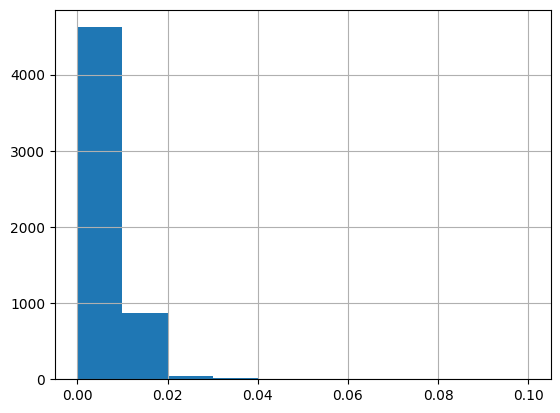

In [49]:
# -- Visualisation of Mean speed distribution for cardiac arrest --
interventionALL_df['Speed Km/sec'].hist()

In [50]:
# -- Calculate Mean speed for arrival time on caridac arrest intervention --
# Speed is computed in km/sec 
mean_speed_kmpsec = interventionALL_df['Speed Km/sec'].mean()
mean_speed_kmpsec

0.0063516871471603195